### 승리 예측 모델을 만들고 feature importance를 구하여 승리기여도 모델을 통해 유저 승리 기여도 분석
-----

#### 분석에 사용 된 라이브러리

In [11]:
# 분석에 사용 된 라이브러리
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns # heatmap
import mglearn
import joblib
import pydotplus
import os
import pandas as pd
import numpy as np
import pickle
import numpy as np
import json
import re 
import time
import ast
from pandas.io.json import json_normalize
import json
from xgboost import XGBClassifier, plot_importance

#### 분석에 사용 된 데이터
match데이터 안에 있는 teams 데이터를 뽑아 분석에 사용(전령,용,타워,억제기 등의 정보가 들어있음)

In [ ]:
#챔피언아이디를 제외하고 딕셔너리를 뽑는다
data = pd.read_csv('MatchTeamsData.csv', index_col=0)
a_ls = list(data['teams'])
#team1
team1_df = pd.DataFrame()
for i in range(len(a_ls)):
    try:
        a_ls[i][0].pop('bans',None)
        team1 = pd.DataFrame(list(a_ls[i][0].values()),index = list(a_ls[i][0].keys())).T
        team1_df = team1_df.append(team1)
    except:
        pass
    
team1_df.index = range(len(team1_df))

#team2
team2_df = pd.DataFrame()
for i in range(len(a_ls)):
    try:
        a_ls[i][1].pop('bans',None)
        team2 = pd.DataFrame(list(a_ls[i][1].values()),index = list(a_ls[i][1].keys())).T
        team2_df = team2_df.append(team2)
    except:
        pass
    
team2_df.index = range(len(team2_df))

#컬럼으로 풀어준 team1과 team2와 duration의 데이터를 합쳐준다.
data_team = pd.concat([team1_df,team2_df,data[['gameDuration']]],axis=1)

#### 승리팀과 패배팀을 나누어 분석 진행

In [12]:
winner_data = pd.read_csv("C:/Users/dlagh/Desktop/match_winner.csv")
loser_data = pd.read_csv('C:/Users/dlagh/Desktop/match_loser.csv')
plus_data = pd.read_csv('C:/Users/dlagh/Desktop/match.csv')

### 분석을 위한 전처리

#### nan값 제거

In [13]:
print(winner_data['win'].unique())
print(loser_data['win'].unique())

# Nan값 제거
lose_data = loser_data.dropna(axis=0)

['Win']
['Fail' nan]


#### 10만 게임중 서로다른 게임끼리의 학습을 위해 분리

In [14]:
winner_data.sample(5)
lose_data.sample(5)

win_data = winner_data[:50415]
lose_data = lose_data[50414:]

In [15]:
# 데이터 결합
win_data.sample(5)
lose_data.sample(5)

lol_data = pd.merge(win_data,lose_data, how="outer")
lol_data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [16]:
# 데이터 셔플
lol_data_shuffle = lol_data.sample(frac=1).reset_index(drop=True)

# 데이터 전처리 불필요한 열 제거
lol_data_shuffle = lol_data_shuffle.drop(['bans','gameId'], axis = 1)

# 추가 데이터 전처리 불필요한 열 제거
plus_data = plus_data.drop(['gameId'],axis = 1)

In [17]:
# 데이터 전처리과정
lol_data_shuffle = lol_data_shuffle.drop(['teamId','dominionVictoryScore','vilemawKills'],axis = 1)
plus_data = plus_data.drop(['teamId'],axis = 1)

lol_data_shuffle = lol_data_shuffle.replace('Win',1)
lol_data_shuffle = lol_data_shuffle.replace('Fail',0)
plus_data = plus_data.replace('Win',1)
plus_data = plus_data.replace('Fail',0)

In [18]:
# 추가 데이터(약 7만개) + 기존 데이터(약 11만개)
add_data = pd.concat([lol_data_shuffle,plus_data], ignore_index = True)

### 매치데이터 시각화

In [34]:
## 데이터 통계

# 첫번째 킬한 상황
win_kill_data = add_data[add_data['win']==1.0]['firstBlood']
win_firstblood = win_kill_data.value_counts(normalize=True)

lose_kill_data = add_data[add_data['win']==0.0]['firstBlood']
# print(data2.value_counts(normalize=True))
lose_firstblood = lose_kill_data.value_counts(normalize=True)

# print('Game win : \n',win_firstblood)
# print('Game lose : \n',lose_firstblood)


# 첫번째 타워 먹은 상황
win_tower_data = add_data[add_data['win']==1.0]['firstTower']
win_firsttower = win_tower_data.value_counts(normalize=True)

lose_tower_data = add_data[add_data['win']==0.0]['firstTower']
lose_firsttower = lose_tower_data.value_counts(normalize=True)


# 첫번째 억제기 먹은 상황
win_inhib_data = add_data[add_data['win']==1.0]['firstInhibitor']
win_Inhibit = win_inhib_data.value_counts(normalize=True)

lose_inhib_data = add_data[add_data['win']==0.0]['firstInhibitor']
lose_Inhibit = lose_inhib_data.value_counts(normalize=True)
# print(win_Inhibit)
# print(lose_Inhibit)
# 첫번째 바론 먹은 상황
win_baron_data = add_data[add_data['win']==1.0]['firstBaron']
win_firstbaron = win_baron_data.value_counts(normalize=True)

lose_baron_data = add_data[add_data['win']==0.0]['firstBaron']
lose_firstbaron = lose_baron_data.value_counts(normalize=True)


# 첫번째 용 먹은 상황
win_dragon_data = add_data[add_data['win']==1.0]['firstDragon']
win_firstdragon = win_dragon_data.value_counts(normalize=True)

lose_dragon_data = add_data[add_data['win']==0.0]['firstDragon']
lose_firstdragon = lose_dragon_data.value_counts(normalize=True)


# 첫번째 전령 먹은 상황
win_riftherald_data = add_data[add_data['win']==1.0]['firstRiftHerald']
win_firstriftherald = win_riftherald_data.value_counts(normalize=True)

lose_riftherald_data = add_data[add_data['win']==0.0]['firstRiftHerald']
lose_firstriftherald = lose_riftherald_data.value_counts(normalize=True)


print("0은 오브젝트x, 1은 오브젝트 획득")
data_weight = pd.DataFrame({'WinGame_Firstkill':[win_firstblood[0],win_firstblood[1]],
                           'LoseGame_Firstkill':[lose_firstblood[0],lose_firstblood[1]],
                           
                            'WinGame_firsttower':[win_firsttower[0],win_firsttower[1]],
                           'LoseGame_firsttower':[lose_firsttower[0],lose_firsttower[1]],
                         
                            'WinGame_firstInhibit':[win_Inhibit[0],win_Inhibit[1]],
                           'LoseGame_firstInhibit':[lose_Inhibit[0],lose_Inhibit[1]],
                          
                            'WinGame_firstbaron':[win_firstbaron[0],win_firstbaron[1]],
                           'LoseGame_firstbaron':[lose_firstbaron[0],lose_firstbaron[1]],
                            
                           'WinGame_firstdragon':[win_firstdragon[0],win_firstdragon[1]],
                           'LoseGame_firstdragon':[lose_firstdragon[0],lose_firstdragon[1]],
                         
                            'WinGame_firstriftherald':[win_firstriftherald[0],win_firstriftherald[1]],
                           'LoseGame_firstriftherald':[lose_firstriftherald[0],lose_firstriftherald[1]],
                           })

print(data_weight)
a = np.array(data_weight)
print(a[0])
print(a[1])

0은 오브젝트x, 1은 오브젝트 획득
   WinGame_Firstkill  LoseGame_Firstkill  WinGame_firsttower  \
0           0.396899            0.601059            0.260374   
1           0.603101            0.398941            0.739626   

   LoseGame_firsttower  WinGame_firstInhibit  LoseGame_firstInhibit  \
0             0.732654               0.31526               0.940678   
1             0.267346               0.68474               0.059322   

   WinGame_firstbaron  LoseGame_firstbaron  WinGame_firstdragon  \
0            0.579118             0.914322             0.448931   
1            0.420882             0.085678             0.551069   

   LoseGame_firstdragon  WinGame_firstriftherald  LoseGame_firstriftherald  
0              0.712084                 0.404461                  0.679182  
1              0.287916                 0.595539                  0.320818  
[0.396899   0.60105944 0.26037431 0.73265381 0.31526004 0.94067778
 0.57911821 0.914322   0.44893106 0.71208371 0.40446125 0.67918241]
[0.6

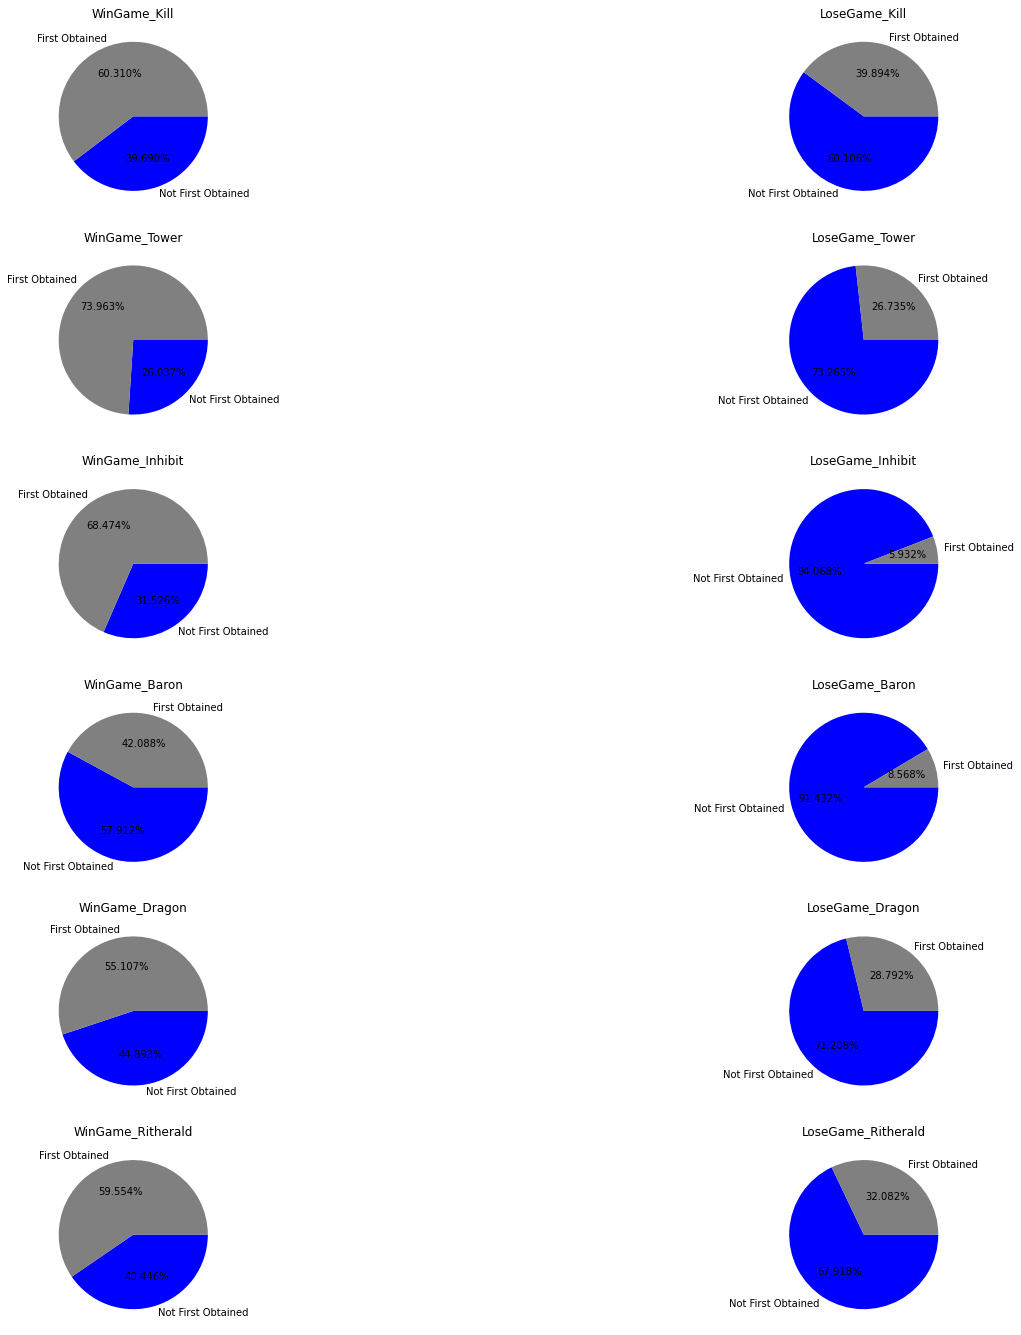

In [35]:
# 데이터 시각화

# 총 17만개의 게임경기 데이터
colors = ['blue', 'gray']
fig, axes = plt.subplots(6,2,figsize=(24,24))

num = 0
for i in range(6):
    for j in range(2):
        axes[i][j].pie((a[0][num],a[1][num]),labels=['Not First Obtained','First Obtained'],autopct='%.3f%%', startangle=360, counterclock=False, colors = colors)
        num += 1

axes[0][0].set_title("WinGame_Kill")
axes[0][1].set_title("LoseGame_Kill")        
axes[1][0].set_title("WinGame_Tower")
axes[1][1].set_title("LoseGame_Tower")    
axes[2][0].set_title("WinGame_Inhibit")
axes[2][1].set_title("LoseGame_Inhibit")    
axes[3][0].set_title("WinGame_Baron")
axes[3][1].set_title("LoseGame_Baron")  
axes[4][0].set_title("WinGame_Dragon")
axes[4][1].set_title("LoseGame_Dragon")    
axes[5][0].set_title("WinGame_Ritherald")
axes[5][1].set_title("LoseGame_Ritherald")    

plt.show()

### 데이터 학습

1. Logistic Regression

c:\Users\dlagh\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


정확도 :  0.8552176133461953
[[16147  2170]
 [ 2933 13996]]


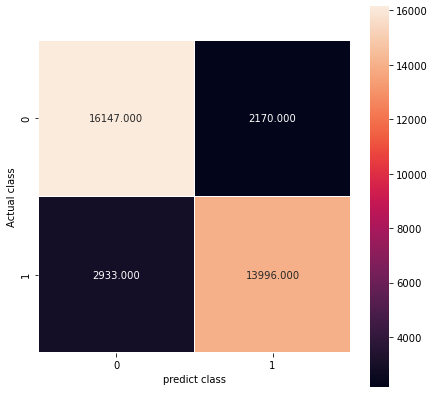

In [29]:
add_data = add_data.replace(True,1)
add_data = add_data.replace(False,0)

train_x = np.array(pd.DataFrame(add_data, columns=['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald',
                                                          'towerKills','inhibitorKills','baronKills','dragonKills','riftHeraldKills']))  

train_y = np.array(pd.DataFrame(add_data, columns=['win'])) 

train_x = train_x.astype(np.int64)
train_y = train_y.astype(np.int64)



X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=46)

clf = LogisticRegression(random_state = 46)
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)

accuracy_score(Y_test,y_pred)
print("정확도 : ",accuracy_score(Y_test,y_pred))

conf_mat = confusion_matrix(Y_test,y_pred)
print(confusion_matrix(Y_test,y_pred))

plt.figure(figsize=(7,7))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("Actual class")
plt.xlabel("predict class")
plt.show()

2. Dicision Tree

정확도 :  0.8722124496396754


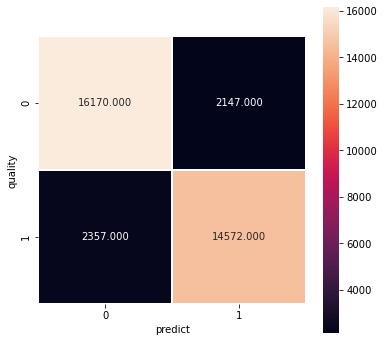

5 폴드세트 0.873265003778199
6 폴드세트 0.8725046247432274
7 폴드세트 0.8719144694749446
8 폴드세트 0.8729131806631111
9 폴드세트 0.8727315830373485
10 폴드세트 0.8731515166069856
11 폴드세트 0.8730550473239319
12 폴드세트 0.8726804819437182
13 폴드세트 0.8728110482306934
14 폴드세트 0.8730436772889235


In [30]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, Y_train)
df_prediction = dt_clf.predict(X_test)

print("정확도 : ", accuracy_score(Y_test,df_prediction))

conf_mat = confusion_matrix(Y_test,df_prediction)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("quality")
plt.xlabel("predict")
plt.show()


for i in range(5,15):
    kf = StratifiedKFold(n_splits=i, shuffle = True)
    score = cross_val_score(dt_clf, train_x, train_y, cv = kf, scoring="accuracy")
    print(i,"폴드세트",score.mean())

3. Random Forest

<ipython-input-31-bbcc9da0d4ec>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, Y_train)
c:\Users\dlagh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\dlagh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\dlagh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

0.8786387974735457
정확도 :  0.8779152244226295


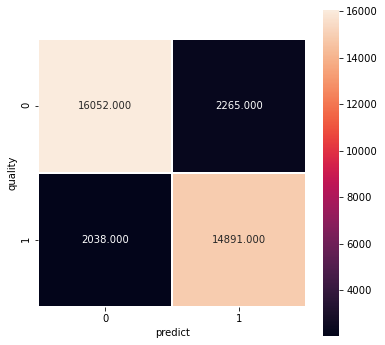

In [31]:
forest=RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf = 3, min_samples_split = 10)

forest.fit(X_train, Y_train)

forest_prediction = forest.predict(X_test)


kf = StratifiedKFold(n_splits=5, shuffle = True)
score = cross_val_score(forest, train_x, train_y, cv = kf, scoring="accuracy")
print(score.mean())

print("정확도 : ", accuracy_score(Y_test,forest_prediction))

conf_mat = confusion_matrix(Y_test,forest_prediction)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("quality")
plt.xlabel("predict")
plt.show()

4. XGBoost

[0]	validation_0-logloss:0.35794
[1]	validation_0-logloss:0.32120
[2]	validation_0-logloss:0.31099
[3]	validation_0-logloss:0.30605
[4]	validation_0-logloss:0.30137


c:\Users\dlagh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\dlagh\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[5]	validation_0-logloss:0.30000
[6]	validation_0-logloss:0.29846
[7]	validation_0-logloss:0.29806
[8]	validation_0-logloss:0.29688
[9]	validation_0-logloss:0.29567
[10]	validation_0-logloss:0.29388
[11]	validation_0-logloss:0.29360
[12]	validation_0-logloss:0.29225
[13]	validation_0-logloss:0.29230
[14]	validation_0-logloss:0.29230
[15]	validation_0-logloss:0.29162
[16]	validation_0-logloss:0.29146
[17]	validation_0-logloss:0.29112
[18]	validation_0-logloss:0.29090
[19]	validation_0-logloss:0.29051
[20]	validation_0-logloss:0.29050
[21]	validation_0-logloss:0.29053
[22]	validation_0-logloss:0.29067
[23]	validation_0-logloss:0.29061
[24]	validation_0-logloss:0.29019
[25]	validation_0-logloss:0.29009
[26]	validation_0-logloss:0.29009
[27]	validation_0-logloss:0.29006
[28]	validation_0-logloss:0.29012
[29]	validation_0-logloss:0.29025
[30]	validation_0-logloss:0.29022
[31]	validation_0-logloss:0.29006
[32]	validation_0-logloss:0.28994
[33]	validation_0-logloss:0.28995
[34]	validation_0-l

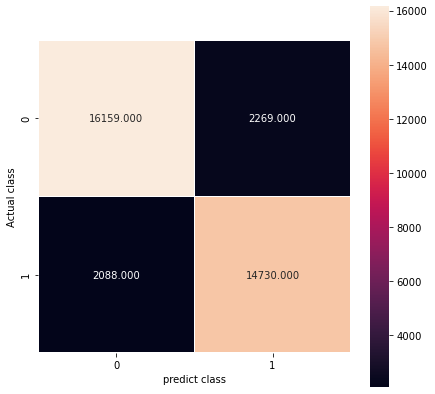

In [32]:

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=48)

# xgb = XGBClassifier(n_estimators = 300, learning_rate = 1, max_depth = 4)
xgb = XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1, monotone_constraints='()',
                                     n_estimators=300, n_jobs=48,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None)

evals = [(X_test,Y_test)]
xgb.fit(X_train, Y_train, early_stopping_rounds = 100, eval_metric='logloss', eval_set = evals, verbose=True)

# xgb.fit(X_train, Y_train)

y_pred = xgb.predict(X_test)

accuracy_score(Y_test,y_pred)
print("정확도 : ",accuracy_score(Y_test,y_pred))

conf_mat = confusion_matrix(Y_test,y_pred)
print(confusion_matrix(Y_test,y_pred))

plt.figure(figsize=(7,7))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("Actual class")
plt.xlabel("predict class")
plt.show()

### feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

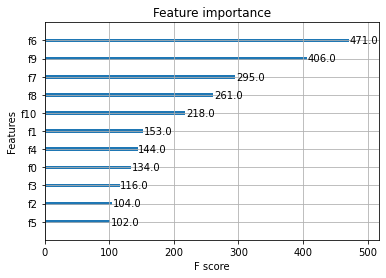

In [33]:
fig, ax = plt.subplots()
plot_importance(xgb, ax = ax)

rank                 weight factor
1.타워수(f6)         0.19
2.용수 (f9)          0.17
3.억제기수(f7)       0.12
4.바론수(f8)         0.10
5.전령수(f10)        0.09
6.타워(f1)           0.06
7.용(f4)            0.06
8.킬(f0)            0.05
9.바론(f3)          0.05
10.억제기(f2)        0.04
11.전령(f5)         0.04

### feature importance를 기반으로 weight factor 을 정하고 이를 통해 contribution Linear model 생성

contribution Linear model
--
C = 0.19F6 + 0.17F9 + 0.12F7 + 0.10F8 + 0.09F10 + 0.06F1 + 0.06F4 + 0.05F0 + 0.05F3 + 0.04F2 + 0.04F5 

##### 모든 지표는 최근 20게임 평균을 기준으로 계산 예정